<a href="https://colab.research.google.com/github/ivelin/donut_ui_refexp/blob/main/Inference_Playground_Donut_UI_RefExp_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://huggingface.co/spaces/ivelin/ui-refexp/


Cloning into 'ui-refexp'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 172 (delta 101), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (172/172), 464.20 KiB | 3.36 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [2]:
!cd ui-refexp/ && pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-amoc1c9p
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-amoc1c9p
  Resolved https://github.com/huggingface/transformers.git to commit 1eda4a410298d57156d44bfc39a6001a72554412
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.26.0.dev0-py3-none-any.whl size=6294537 sha256=ba74d4f13027b22fd5a46b32c54359840c83794fdb9f88c20faaf86311703a8b
  Stored in directory: /tm

In [112]:
import re
from PIL import Image, ImageDraw
import math
import torch
import html
from transformers import DonutProcessor, VisionEncoderDecoderModel



In [113]:
pretrained_repo_name = "./saved_pretrained (1)"
print(f"Loading model checkpoint: {pretrained_repo_name}")

processor = DonutProcessor.from_pretrained(pretrained_repo_name)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading model checkpoint: ./saved_pretrained (1)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [132]:

def process_refexp(image: Image, prompt: str):

    print(f"(image, prompt): {image}, {prompt}")

    # trim prompt to 80 characters and normalize to lowercase
    prompt = prompt[:80].lower()

    # prepare encoder inputs
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # prepare decoder inputs
    task_prompt = "<s_refexp><s_prompt>{user_input}</s_prompt><s_target_bounding_box>"
    prompt = task_prompt.replace("{user_input}", prompt)
    decoder_input_ids = processor.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # generate answer
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    
    # postprocess
    sequence = processor.batch_decode(outputs.sequences)[0]
   
    
    print(fr"predicted decoder sequence: {html.escape(sequence)}")
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    # remove first task start token
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()
    print(
        fr"predicted decoder sequence before token2json: {html.escape(sequence)}")
    seqjson = processor.token2json(sequence)

    # safeguard in case predicted sequence does not include a target_bounding_box token
    bbox = seqjson.get('target_bounding_box')
    print(f"bounding box is {bbox}")
    if bbox is None:
#         print(
#             f"token2bbox seq has no predicted target_bounding_box, seq:{seq}")
        bbox = {"xmin": 0, "ymin": 0, "xmax": 0, "ymax": 0}
        return None, bbox

    print(f"predicted bounding box with text coordinates: {bbox}")
    # safeguard in case text prediction is missing some bounding box coordinates
    # or coordinates are not valid numeric values
    try:
        xmin = float(bbox.get("xmin", 0))
    except ValueError:
        xmin = 0
    try:
        ymin = float(bbox.get("ymin", 0))
    except ValueError:
        ymin = 0
    try:
        xmax = float(bbox.get("xmax", 1))
    except ValueError:
        xmax = 1
    try:
        ymax = float(bbox.get("ymax", 1))
    except ValueError:
        ymax = 1
    # replace str with float coords
    bbox = {"xmin": xmin, "ymin": ymin, "xmax": xmax,
            "ymax": ymax, "decoder output sequence": sequence}
    print(f"predicted bounding box with float coordinates: {bbox}")

    print(f"image object: {image}")
    print(f"image size: {image.size}")
    width, height = image.size
    print(f"image width, height: {width, height}")
    print(f"processed prompt: {prompt}")

    # safeguard in case text prediction is missing some bounding box coordinates
    xmin = math.floor(width*bbox["xmin"])
    ymin = math.floor(height*bbox["ymin"])
    xmax = math.floor(width*bbox["xmax"])
    ymax = math.floor(height*bbox["ymax"])

    print(
        f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}")

    shape = [(xmin, ymin), (xmax, ymax)]

    # deaw bbox rectangle
    img1 = ImageDraw.Draw(image)
    img1.rectangle(shape, outline="blue", width=5)
    img1.rectangle(shape, outline="white", width=2)

    return image, bbox

In [133]:
from typing import Tuple
import numpy as np
from PIL import ImageOps
def resize_and_pad_image(img, size: Tuple[int, int], bbox=None):
    """
    Resize an image to a target size and add padding if necessary.
    
    Args:
        img (PIL.Image): The input image.
        size (tuple): The target size, as a (width, height) tuple.
        bbox (dict): The bounding box coordinates, as a dictionary with keys 'xmin', 'ymin', 'xmax', and 'ymax'.
        
    Returns:
        PIL.Image: The resized and padded image.
        dict: The adjusted bounding box coordinates, as a dictionary with keys 'xmin', 'ymin', 'xmax', and 'ymax'.
    """
    
    if img.mode[-1] == 'A':
        img = img.convert('RGB')
    
    # Compute the aspect ratio of the original image.
    aspect_ratio = img.size[0] / img.size[1]
    
    # Compute the aspect ratio of the target size.
    target_aspect_ratio = size[0] / size[1]
    
    # If the aspect ratios are the same, just resize the image.
    if np.isclose(aspect_ratio, target_aspect_ratio):
        new_size = size
    else:
        # Compute the size of the image after resizing to fit the width.
        new_size = (int(size[0]), int(size[0] / aspect_ratio))
    
    # If the resulting height is less than the target height, add padding to the top and bottom.
    if new_size[1] < size[1]:
        padding_top = (size[1] - new_size[1]) // 2
        padding_bottom = size[1] - new_size[1] - padding_top
        padding_left = 0
        padding_right = 0
        img = img.resize(new_size, Image.BICUBIC)
        img = ImageOps.expand(img, (0, padding_top, 0, padding_bottom), fill=0)
    else:
        # Otherwise, add padding to the left and right.
        padding_left = (new_size[0] - size[0]) // 2
        padding_right = new_size[0] - size[0] - padding_left
        padding_top = 0
        paading_bottom = 0
        img = img.resize(new_size, Image.BICUBIC)
        img = ImageOps.expand(img, (padding_left, 0, padding_right, 0), fill=0)


    # Adjust the bounding box coordinates, if provided.
    if bbox is not None:
        adjusted_bbox = {
            'xmin': bbox['xmin'] * new_size[0] + padding_left,
            'ymin': bbox['ymin'] * new_size[1] + padding_top,
            'xmax': bbox['xmax'] * new_size[0] + padding_left,
            'ymax': bbox['ymax'] * new_size[1] + padding_top
        }
        
        return img, adjusted_bbox
    else:
        return img, None
    
    return resized_img, adjusted_bbox

In [134]:
IMAGE_PATH: str = './images/22b234b1-Снимок_экрана_2023-03-13_в_21.58.15.png'
from PIL import Image

image = Image.open(IMAGE_PATH)

image, _ = resize_and_pad_image(image, (1920, 1080))

C:\Users\evgenii.saurov\AppData\Local\Temp\ipykernel_19604\3993152455.py:40: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize(new_size, Image.BICUBIC)


In [135]:
PROMPT: str = "Microsoft Excel"

In [136]:
image, bbox = process_refexp(image, PROMPT)

(image, prompt): <PIL.Image.Image image mode=RGB size=1920x1080 at 0x2196EC7A700>, Microsoft Excel
predicted decoder sequence: &lt;s_refexp&gt;&lt;s_prompt&gt; microsoft excel&lt;/s_prompt&gt;&lt;s_target_bounding_box&gt;&lt;s_xmin&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymax&gt;&lt;/s_target_bounding_box&gt;&lt;/s&gt;
predicted decoder sequence before token2json: &lt;s_prompt&gt; microsoft excel&lt;/s_prompt&gt;&lt;s_target_bounding_box&gt;&lt;s_xmin&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymin&gt;&lt;s_xmax&gt; 0.97&lt;/s_ymax&gt;&lt;/s_target_bounding_box&gt;
bounding box is None


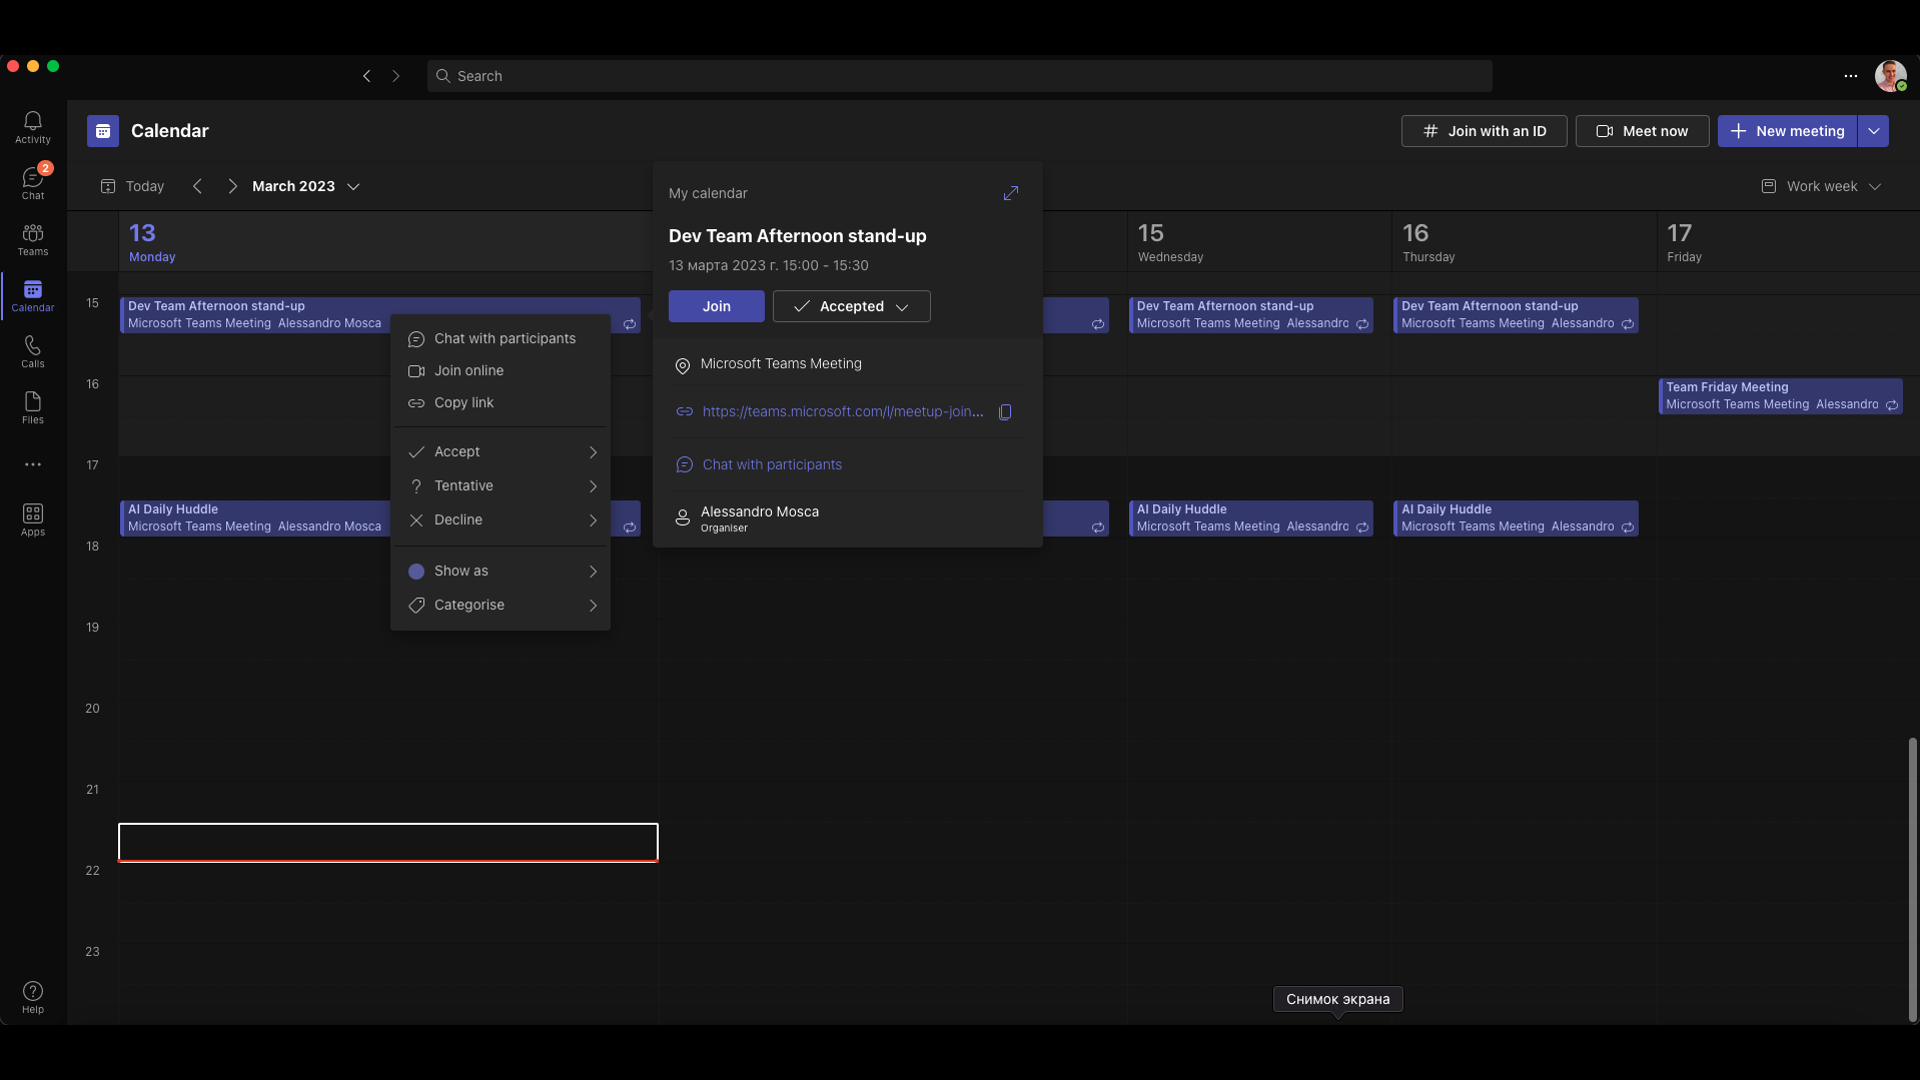

In [131]:
image